In [0]:
#!pip install deap

## Librerías

In [0]:
import random                         # Se utiliza para generar números aleatorios
import numpy as np                    # Se utiliza para provechar sus funciones matemáticas
import matplotlib.pyplot as plt       # Se utiliza para graficar
from deap import base, creator, tools # Framework

## Funciones

### Función para imprimir un sudoku

In [0]:
# Recibe como parámetro una lista con 81 elementos
def imprime_sudoku(sudoku):
    x = 0 # Equivale al rango de...
    y = 3 # los 3 primeros valores del sudoku

    iteracion = 0
    while iteracion < 9: # Los primeros 9 valores conforman la primera fila
        if iteracion == 3 or iteracion == 6:
            print("----- + ----- + -----")

        for i in range(x, y):
            print(sudoku[i], end=" ")
        print("| ", end="")
        x += 3
        y += 3

        for i in range(x, y):
            print(sudoku[i], end=" ")
        print("| ", end="")
        x += 3
        y += 3

        for i in range(x, y):
            print(sudoku[i], end=" ")
        print()
        x += 3
        y += 3

        iteracion += 1

### Función fitness

In [0]:
# Retorna el fitness de un sudoku dado, recibe como parámetro una lista con 81 elementos
def calcula_fitness(sudoku):
    # Retorna la cantidad de números repetidos en una fila, columna o sector, recibe como parámetro una lista con 81 elementos
    def repetidos(aux):
        fit = 0                            # Fitness
        if len(aux) != len(set(aux)):      # Si el tamaño de la fila, columna o sector (con todos los valores, incluyendo los repetidos) es distindo
                                           # al tamaño sin incluir los valores repetidos...
            fit = len(aux) - len(set(aux)) # Fitness toma el valor del resultado de la diferencia
        return fit

    # Recorre las filas o las columnas del sudoku, recibe como parámetros una lista con 81 elementos que representa el sudoku entero, una lista
    # con 9 elementos que representa la primera fila o columna del sudoku, y un valor entero que representa el desplazamiento, que depende si el
    # parámetro anterior es una fila o una columna
    def evalua_filas_o_columnas(sudoku, fil_col, desplazamiento):
        iteracion = 0
        fit = 0 # Fitness
        while iteracion < 9: # 9 columnas o filas
            aux = list() # Lista auxiliar

            # Cada elemento del sudoku en la columna o fila se añade a una lista auxiliar
            for i in fil_col:
                aux.append(sudoku[i])

            # Se calcula el fitness de la columna o fila (representada en la lista auxiliar)
            fit += repetidos(aux) # Se incrementa el valor actual del fitness con el resultado devuelo

            # Desplazamiento para evaluar la siguiente columna o fila
            for i in range(0, len(fil_col)):
                fil_col[i] += desplazamiento

            iteracion += 1
        return fit

    # Retorna, iterativamente, cada uno de los sectores del sudoku, recibe como parámetros una lista de 81 elementos que representa el sudoku...
    # y un número entero que representa la posición del primer elemento ubicado en la esquina superior izquierda del sector
    def recorre_sectores(sudoku, posicion):
        # Posiciones del primer sector ubicado en la esquina superior izquierda
        sector = [
            sudoku[posicion+0+0],  sudoku[posicion+1+0],  sudoku[posicion+2+0],
            sudoku[posicion+0+9],  sudoku[posicion+1+9],  sudoku[posicion+2+9],
            sudoku[posicion+0+18], sudoku[posicion+1+18], sudoku[posicion+2+18]
        ]
        return sector
    
    fitness  = 0 # Fitness global
    columnas = [0, 9, 18, 27, 36, 45, 54, 63, 72] # Posiciones de la primera columna de izquierda a derecha
    filas    = [0, 1, 2, 3, 4, 5, 6, 7, 8]        # Posiciones de la primera fila de arriba hacia abajo
    
    # Evalúa las columnas
    fitness += evalua_filas_o_columnas(sudoku, columnas, 1)
        
    # Evalúa las filas
    fitness += evalua_filas_o_columnas(sudoku, filas, 9)
        
    # Evalúa los sectores
    posiciones_sectores = [0, 3, 6, 27, 30, 33, 54, 57, 60] # Posiciones del primer elemento (esquina superior izquierda) de cada sector
    for i in posiciones_sectores:
        aux = recorre_sectores(sudoku, i) # Obtiene el sector dado su primer elemento (esquina superior izquierda)
        fitness += repetidos(aux)         # Calcula e incrementa el fitness

    return (float(fitness),)

### Función de mutación, copiada del libro Clinton Sheppard - Genetic Algorithms with Python (2016)

In [0]:
def shuffle_in_place(genes, first, last):
    while first < last:
        index = random.randint(first, last)
        genes[first], genes[index] = genes[index], genes[first]
        first += 1

def index_row(index):
    return int(index / 9)

def index_column(index):
    return int(index % 9)

def row_column_section(row, column):
    return int(row / 3) * 3 + int(column / 3)

def section_start(index):
    return int((index_row(index) % 9) / 3) * 27 + int(
        index_column(index) / 3) * 3

def build_validation_rules():
    rules = []
    for index in range(80):
        itsRow = index_row(index)
        itsColumn = index_column(index)
        itsSection = row_column_section(itsRow, itsColumn)

        for index2 in range(index + 1, 81):
            otherRow = index_row(index2)
            otherColumn = index_column(index2)
            otherSection = row_column_section(otherRow, otherColumn)
            if itsRow == otherRow or \
                            itsColumn == otherColumn or \
                            itsSection == otherSection:
                rules.append(Rule(index, index2))

    rules.sort(key=lambda x: x.OtherIndex * 100 + x.Index)
    return rules

class Rule:
    def __init__(self, it, other):
        if it > other:
            it, other = other, it
        self.Index = it
        self.OtherIndex = other

    def __eq__(self, other):
        return self.Index == other.Index and \
               self.OtherIndex == other.OtherIndex

    def __hash__(self):
        return self.Index * 100 + self.OtherIndex

validationRules = build_validation_rules()

def mutate(genes, validationRules):
    selectedRule = next(rule for rule in validationRules
                        if genes[rule.Index] == genes[rule.OtherIndex])
        
    if selectedRule is None:
        return

    if index_row(selectedRule.OtherIndex) % 3 == 2 \
            and random.randint(0, 10) == 0:
        sectionStart = section_start(selectedRule.Index)
        current = selectedRule.OtherIndex
        while selectedRule.OtherIndex == current:
            shuffle_in_place(genes, sectionStart, 80)
            selectedRule = next(rule for rule in validationRules
                                if genes[rule.Index] == genes[rule.OtherIndex])
        return

    row = index_row(selectedRule.OtherIndex)
    start = row * 9
    indexA = selectedRule.OtherIndex
    indexB = random.randrange(start, len(genes))
    genes[indexA], genes[indexB] = genes[indexB], genes[indexA]

### Funciones copiadas del repositorio https://github.com/GuilhermeFreire/Sudoku_Gen_Alg   
### Facilitan el tratamiento de los valores predeterminados del sudoku a resolver

In [0]:
# Datos, valores fijos del sudoku a resolver
fixedValues = np.array([
                        #(val, row, col)
                        (3, 0, 0),
                        (1, 0, 1),
                        (2, 0, 2),
                        (7, 0, 3),
                        (5, 0, 7),
                        (8, 1, 0),
                        (7, 1, 7),
                        (7, 2, 1),
                        (9, 2, 2),
                        (5, 2, 5),
                        (2, 2, 6),
                        (4, 2, 8),
                        (3, 3, 2),
                        (6, 3, 4),
                        (1, 3, 7),
                        (4, 4, 0),
                        (1, 4, 2)
                        ])

# Une los elementos predeterminados con los individuos generados
def buildBoardFromDNA64(individual):
    flattenedIdx = list(map(lambda t: t[1]*9 + t[2], fixedValues))
    values = fixedValues.T[0]
    flatBoard = []
    fixedValuesCounter = 0
    for i in range(81):
        if(i in flattenedIdx):
            flatBoard.append(values[fixedValuesCounter])
            fixedValuesCounter += 1
            continue
        flatBoard.append(individual[i - fixedValuesCounter])
    return np.array(flatBoard).reshape(9,9)

def printBoardFromDNA64(individual):
    board = buildBoardFromDNA64(individual)
    # Modificación para adaptar a la función impime_sudoku()
    aux_board = list()
    for i in board:
        for j in i:
            aux_board.append(j)
    imprime_sudoku(aux_board)

def fitnessFromDNA64(individual):
    board = buildBoardFromDNA64(individual)
    # Modificación para adaptar a la función calcula_fitness()
    aux_board = list()
    for i in board:
        for j in i:
            aux_board.append(j)
    return calcula_fitness(aux_board)

## Configuración del framework

In [0]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))    # Se crea la clase "FitnessMin", derivada de la clase "base.Fitness"
creator.create("Individual", list, fitness=creator.FitnessMin) # Se crea la clase Individual, representada en el tipo de dato "lista"

# Se instancia el objeto toolbox de la clase "base.Toolbox()". Este objeto contiene el método "register" que se usará a continuación
toolbox = base.Toolbox()

# Se registra la función fitness
toolbox.register("evaluate", fitnessFromDNA64)

TAMANIO_INDIVIDUO = 64 # Tamaño de cada individuo (sudokus aleatorios generados)

# "toolbox.register"() añade un método al objeto "toolbox". Este método es denominado "entero_aleatorio" y llama a la función...
#  "random.randint" generando un número aleatorio entre 1 y 9 (los valores válidos del sudoku)
toolbox.register("entero_aleatorio", random.randint, 1, 9)

# Este método genera un nuevo individuo
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.entero_aleatorio, n=TAMANIO_INDIVIDUO)

# Este método genera una nueva población, llamando al método que genera individuos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operador de cruce. Registra el método para el cruce en 2 puntos
toolbox.register("mate", tools.cxTwoPoint)

# Operador de Selección. El método de selección es por "torneo", tomando como criterio de selección el fitness
toolbox.register("select", tools.selTournament, tournsize=3, fit_attr="fitness")

## Dinámica evolutiva, copiada del ejemplo "One Max Problem" de la documentación del framework DEAP

In [0]:
def dinamica_evolutiva(estadisticas):
    # Función que retorna un diccionario con la media, estándar, máximo y mínimo fitness de cada iteración
    def add_estadisticas(poblacion, iteracion=1):
        fitnesses = [individual.fitness.values[0] for individual in poblacion]
        return {
            "ite" :  iteracion,
            "mean":  np.mean(fitnesses),
            "std" :  np.std(fitnesses),
            "max" :  np.max(fitnesses),
            "min" :  np.min(fitnesses)
        }

    # create an initial population of 400 individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=400)

    # CXPB  is the probability with which two individuals
    #       are crossed
    #
    # MUTPB is the probability for mutating an individual
    CXPB, MUTPB = 0.83, 0.75
    
    print("Start of evolution")
    
    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    print("  Evaluated %i individuals" % len(pop))

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while min(fits) > 0 and g < 300:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)
        
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < CXPB:
                toolbox.mate(child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability MUTPB
            if random.random() < MUTPB:
                mutate(mutant, validationRules)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        print("  Evaluated %i individuals" % len(invalid_ind))
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring

        # Se generan las estadísticas
        estadisticas.append(add_estadisticas(pop, g))
        
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)

    best_ind = tools.selBest(pop, 1)[0]

    return {
        "best_ind" :  best_ind,
        "g"        :  g
    }

## Gráfica

In [0]:
# Se crea un diagrama de dispersión
def grafica(estadisticas):
    plt.scatter(range(1, len(estadisticas)+1), [s["mean"] for s in estadisticas], marker=".")
    plt.title("Promedio de fitness por iteración")
    plt.xlabel("Iteraciones")
    plt.ylabel("Fitness")
    plt.show()

## Main

In [0]:
%%time
estadisticas = list()
resultado = dinamica_evolutiva(estadisticas)
if resultado["best_ind"].fitness.values[0] == 0.0:
    print("\nSOLUCIÓN")
else:
    print("\nMEJOR INDIVIDUO")
printBoardFromDNA64(resultado["best_ind"])
print("Fitness: {}".format(resultado["best_ind"].fitness.values[0]))

Start of evolution
  Evaluated 400 individuals
-- Generation 1 --
  Evaluated 382 individuals
  Min 64.0
  Max 91.0
  Avg 77.32
  Std 4.676815155637596
-- Generation 2 --
  Evaluated 380 individuals
  Min 60.0
  Max 92.0
  Avg 74.14
  Std 4.630917835591614
-- Generation 3 --
  Evaluated 385 individuals
  Min 60.0
  Max 88.0
  Avg 72.14
  Std 4.377259416575599
-- Generation 4 --
  Evaluated 383 individuals
  Min 59.0
  Max 83.0
  Avg 70.1325
  Std 4.420400858519613
-- Generation 5 --
  Evaluated 373 individuals
  Min 55.0
  Max 83.0
  Avg 68.48
  Std 4.5221233950435185
-- Generation 6 --
  Evaluated 390 individuals
  Min 54.0
  Max 78.0
  Avg 66.8575
  Std 4.218079391144691
-- Generation 7 --
  Evaluated 385 individuals
  Min 53.0
  Max 84.0
  Avg 65.68
  Std 4.206851554309887
-- Generation 8 --
  Evaluated 377 individuals
  Min 54.0
  Max 77.0
  Avg 64.5225
  Std 4.244937425922794
-- Generation 9 --
  Evaluated 377 individuals
  Min 51.0
  Max 75.0
  Avg 63.2475
  Std 4.161879833680889

## Gráfica

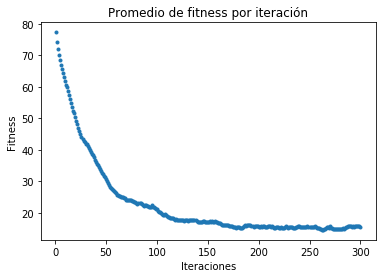

In [0]:
grafica(estadisticas)